## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### **Note that the notebook has been run in several batches as colab keeps crashing for excess RAM usage. So some cells may not be executed in sequence.**

### Load Dataset Files

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import misc
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D, BatchNormalization, GlobalAveragePooling2D

print(tf.__version__)


2.1.0


Using TensorFlow backend.


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
project_path = "/content/drive/My Drive/Colab Notebooks/AIML/res_8/project/"
os.chdir(project_path)

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'sample_submission.csv.zip', 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'labels.csv.zip', 'r') as z:
  z.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [0]:
labels = pd.read_csv('labels.csv')

In [0]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [0]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
id       10222 non-null object
breed    10222 non-null object
dtypes: object(2)
memory usage: 159.8+ KB


### Print the count of each category of Dogs given in the dataset



In [0]:
labels.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

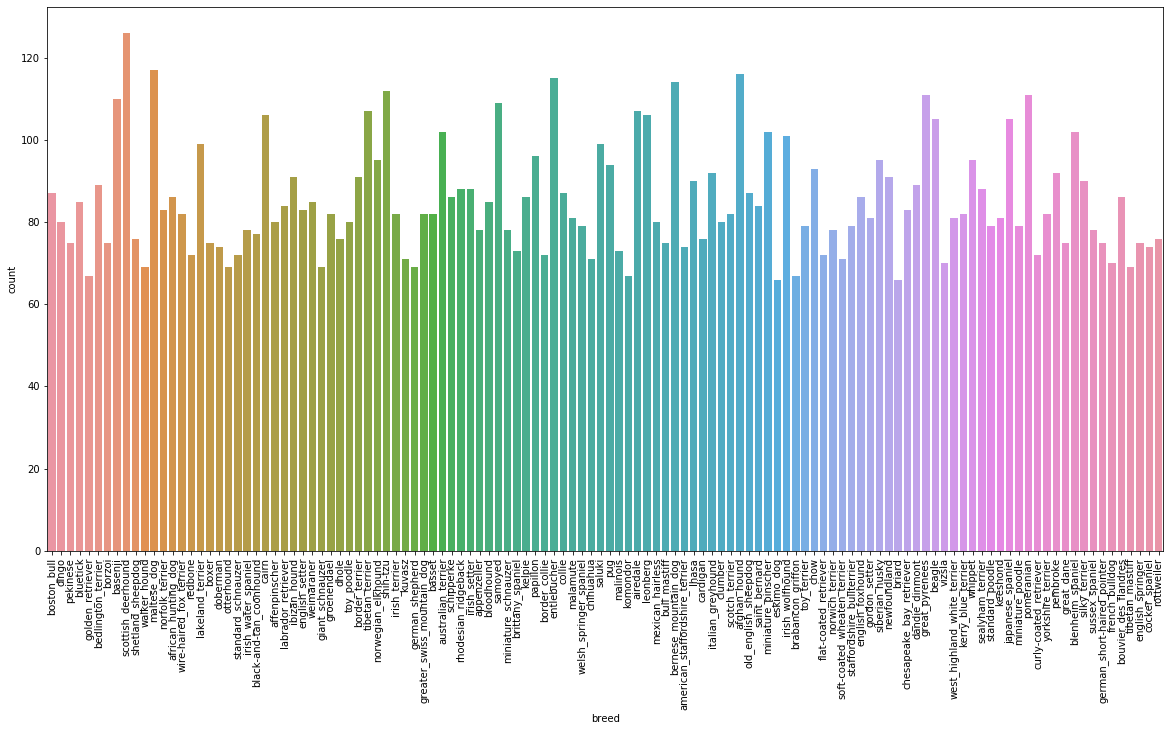

In [0]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20,10))
g = sns.countplot(x='breed',data=labels);
plt.xticks(rotation=90);

### **The top 20 breeds represented in the data are listed below:**

In [0]:
labels.breed.value_counts().sort_values(ascending = False).head(20)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
pomeranian              111
great_pyrenees          111
basenji                 110
samoyed                 109
airedale                107
tibetan_terrier         107
cairn                   106
leonberg                106
beagle                  105
japanese_spaniel        105
miniature_pinscher      102
australian_terrier      102
blenheim_spaniel        102
irish_wolfhound         101
Name: breed, dtype: int64

**The bottom 20 breeds represented in the data are listed below:**

In [0]:
labels.breed.value_counts().sort_values().head(20).sort_values(ascending = False)

border_collie                  72
flat-coated_retriever          72
standard_schnauzer             72
redbone                        72
curly-coated_retriever         72
chihuahua                      71
soft-coated_wheaten_terrier    71
kuvasz                         71
vizsla                         70
french_bulldog                 70
otterhound                     69
german_shepherd                69
walker_hound                   69
tibetan_mastiff                69
giant_schnauzer                69
brabancon_griffon              67
komondor                       67
golden_retriever               67
briard                         66
eskimo_dog                     66
Name: breed, dtype: int64

## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

**(128,128,3), (64,64,3) and (224,224,3) were tried for best accuaracy**

In [0]:
img_rows = 224
img_cols = 224
x_train = []
y_train = []
i = 0 # initialisation
for f, img in tqdm(labels.values): # f for format ,jpg
   
    train_img = cv2.imread('/content/drive/My Drive/Colab Notebooks/AIML/res_8/project/train/{}.jpg'.format(f), 1)
    img_resize = cv2.resize(train_img, (img_rows, img_cols)) 
    x_train.append(img_resize)
    y_train.append(img)
    



100%|██████████| 10222/10222 [01:33<00:00, 109.63it/s]


### Get one-hot encodings of labels

In [0]:
x_train = np.array(x_train, np.float32)
x_train.shape

(10222, 224, 224, 3)

In [0]:
y_train=np.array(y_train).reshape(-1,1)

In [0]:
oe = OneHotEncoder()
y_train = oe.fit_transform(y_train).todense()
y_train = np.array(y_train)

In [0]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [0]:
#x_train_scaled = np.subtract(x_train, np.min(x_train))/np.subtract(np.max(x_train),np.min(x_train))
x_train_scaled = x_train/255.0

 

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train_scaled, y_train, test_size=0.1)
#plt.imshow(X_train[12])

In [0]:
X_train.shape

(9199, 224, 224, 3)

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [0]:
submision = pd.read_csv('sample_submission.csv')

In [8]:
submision.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [0]:
test_img = submision.id

Run the below code to load the test image files in x_test_feature

In [0]:
y_test = submision.drop('id', axis = 1)

**Since the best result is obtained for 224,224,3, the test set is loaded for 224,224,3**

In [12]:
x_test_features = []


i = 0 # initialisation
for f in tqdm(submision.id): # f for format ,jpg
   
    test_img = cv2.imread('./test/{}.jpg'.format(f), 1)
    img_resize = cv2.resize(test_img, (224, 224)) 
    x_test_features.append(img_resize)
    
    

100%|██████████| 10357/10357 [01:24<00:00, 123.18it/s]


In [13]:
x_test = np.array(x_test_features, np.float32)
x_test.shape

(10357, 224, 224, 3)

Normalize the test data and convert it into 4 dimensions

In [14]:
x_test_scaled = x_test/255.0
x_test_scaled.shape

(10357, 224, 224, 3)

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model = tf.keras.models.Sequential()
#normalize data
#model.add(tf.keras.layers.BatchNormalization(input_shape=(img_rows,img_cols,3,)))

#Add Conv Layer
model.add(tf.keras.layers.Conv2D(128, input_shape=(img_rows,img_cols,3,),kernel_size=(5,5), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())



#Add Conv Layer
model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

#Add Conv Layer
#model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu'))





#Add Dense Layers after flattening the data
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())


#Add Output Layer
model.add(tf.keras.layers.Dense(120, activation='softmax'))




In [0]:
#Specify Loass and Optimizer
adm = optimizers.Adam(lr = 1e-3)
model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 128)       9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 256)       295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 58, 256)       1024      
_________________________________________________________________
flatten (Flatten)            (None, 861184)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               220463360 
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

### Use batch_size = 128 and epochs = 10 and execute the model

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
9071/9199 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9991 - val_loss: 4.4714 - val_accuracy: 0.0626dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


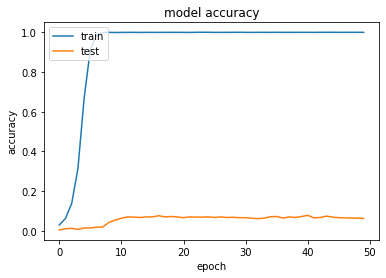

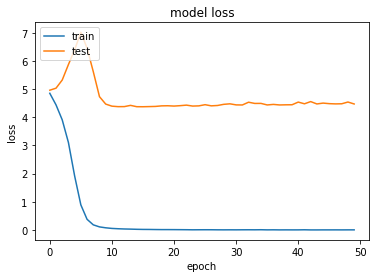

In [0]:
history = model.fit(X_train, Y_train,
          validation_data = (X_val, Y_val),
                    epochs=50,
                    batch_size = 128,steps_per_epoch = len(X_train)//128
                    
                    )
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


Fit the model using fit_generator() using train_generator and val_generator from the above step with 10 epochs

In [0]:
datagen = ImageDataGenerator(
    
   
    shear_range=0.2,
        zoom_range=0.2,
    horizontal_flip=True)



In [0]:
datagen.fit(X_train)

In [0]:
valgen = ImageDataGenerator(
     shear_range=0.2,
        zoom_range=0.2,
    horizontal_flip=True)
valgen.fit(X_val)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 71 steps, validate for 32 steps
Epoch 1/50
71/71 [==============================] - 11s 160ms/step - loss: 5.5308 - accuracy: 0.0488 - val_loss: 31.3742 - val_accuracy: 0.0088
Epoch 2/50
71/71 [==============================] - 11s 152ms/step - loss: 4.6207 - accuracy: 0.0757 - val_loss: 6.4360 - val_accuracy: 0.0186
Epoch 3/50
71/71 [==============================] - 11s 152ms/step - loss: 4.1473 - accuracy: 0.1127 - val_loss: 4.6424 - val_accuracy: 0.0303
Epoch 4/50
71/71 [==============================] - 11s 153ms/step - loss: 3.7486 - accuracy: 0.1605 - val_loss: 4.4992 - val_accuracy: 0.0557
Epoch 5/50
71/71 [==============================] - 11s 153ms/step - loss: 3.4367 - accuracy: 0.2112 - val_loss: 4.3000 - val_accuracy: 0.0645
Epoch 6/50
71/71 [==============================] - 11s 152ms/step - loss: 3.1508 - accuracy: 0.2703 - val_loss: 4.3

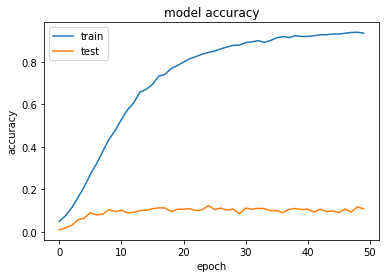

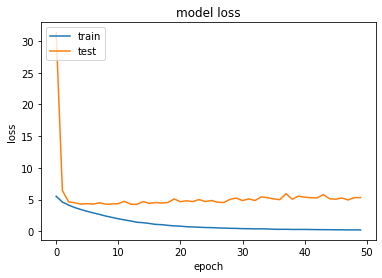

In [0]:
history = model.fit_generator(datagen.flow(X_train, Y_train,batch_size = 128),
          validation_data = valgen.flow(X_val, Y_val),
          steps_per_epoch=len(X_train) // 128,
                    epochs=50
                    
                    
                    )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
base_model= VGG16(weights=(project_path+'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False, pooling='avg', input_shape = (64,64,3))
#tf.keras.backend.clear_session()
#base_model= VGG16(weights='imagenet',
#                 include_top=False, pooling='avg')

Print the summary of the base_model

In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [0]:
new_model = tf.keras.models.Sequential()
new_model.add(base_model)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [0]:



#Add Dense Layers after flattening the data
new_model.add(tf.keras.layers.Flatten())
new_model.add(tf.keras.layers.Dense(1024, activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.5))
new_model.add(tf.keras.layers.BatchNormalization())
#new_model.add(tf.keras.layers.Dense(4096, activation='relu'))
#new_model.add(tf.keras.layers.BatchNormalization())
#new_model.add(tf.keras.layers.Dense(4096, activation='relu'))
#new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Dense(256, activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.5))
new_model.add(tf.keras.layers.BatchNormalization())

#Add Output Layer
new_model.add(tf.keras.layers.Dense(120, activation='softmax'))

### Make all the layers in the base_model (VGG16) to be non-trainable

In [0]:
for layer in new_model.layers[:1]:
  layer.trainable = False

In [0]:
for layer in new_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.training.Model object at 0x7fb90016ee10> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7fb900141cc0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fb900141cf8> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7fb900141ef0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb9000c3668> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fb9000c32e8> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7fb9000d9a58> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb900100f98> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fb900100e80> True


In [0]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [0]:
#Specify Loass and Optimizer
adm = optimizers.Adam(lr = 0.0001)
new_model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('first_model3.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=2)

  ...
    to  
  ['...']
Train for 71 steps, validate on 1023 samples
Epoch 101/200
70/71 [============================>.] - ETA: 0s - loss: 3.4097 - accuracy: 0.2041
Epoch 00101: val_accuracy did not improve from 0.13881
71/71 [==============================] - 9s 121ms/step - loss: 3.4119 - accuracy: 0.2038 - val_loss: 3.9304 - val_accuracy: 0.1329
Epoch 102/200
70/71 [============================>.] - ETA: 0s - loss: 3.3992 - accuracy: 0.2080
Epoch 00102: val_accuracy did not improve from 0.13881
71/71 [==============================] - 9s 125ms/step - loss: 3.4002 - accuracy: 0.2079 - val_loss: 3.9307 - val_accuracy: 0.1271
Epoch 103/200
70/71 [============================>.] - ETA: 0s - loss: 3.4124 - accuracy: 0.2057
Epoch 00103: val_accuracy did not improve from 0.13881
71/71 [==============================] - 9s 122ms/step - loss: 3.4116 - accuracy: 0.2059 - val_loss: 3.9255 - val_accuracy: 0.1339
Epoch 104/200
70/71 [============================>.] - ETA: 0s - loss: 3.3916 - a

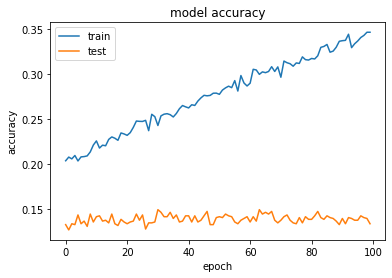

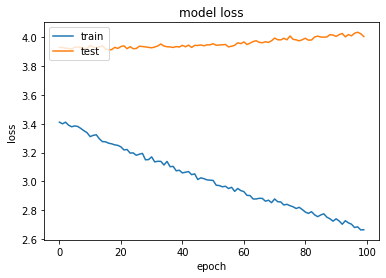

In [0]:
history = new_model.fit_generator(datagen.flow(X_train, Y_train,batch_size = 128),
          validation_data = (X_val, Y_val),
          steps_per_epoch=len(X_train) // 128,
                    epochs=200, initial_epoch = 100, 
               callbacks = [model_checkpoint]
                    
                    )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### So far we have looked at only 64x64 images. Let us see if the accuarcy imporves with 224x224 (default for VGG16) size images

In [0]:
base_model224= VGG16(weights=(project_path+'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False, pooling='avg', input_shape = (224,224,3))

In [0]:
base_model224.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
new_model224 = tf.keras.models.Sequential()
new_model224.add(base_model224)
new_model224.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Add Dense Layers after flattening the data
new_model224.add(tf.keras.layers.Flatten())
new_model224.add(tf.keras.layers.Dense(1024, activation='relu'))
new_model224.add(tf.keras.layers.Dropout(0.5))
new_model224.add(tf.keras.layers.BatchNormalization())
#new_model.add(tf.keras.layers.Dense(4096, activation='relu'))
#new_model.add(tf.keras.layers.BatchNormalization())
#new_model.add(tf.keras.layers.Dense(4096, activation='relu'))
#new_model.add(tf.keras.layers.BatchNormalization())
new_model224.add(tf.keras.layers.Dense(256, activation='relu'))
new_model224.add(tf.keras.layers.Dropout(0.5))
new_model224.add(tf.keras.layers.BatchNormalization())

#Add Output Layer
new_model224.add(tf.keras.layers.Dense(120, activation='softmax'))

In [0]:
for layer in new_model224.layers[:1]:
  layer.trainable = False

for layer in new_model224.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.training.Model object at 0x7f9be0223eb8> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7f9be019f8d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9be019f908> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9be019fda0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f9be019fd68> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9be019a128> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9be0143ef0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f9be00f9d68> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9be00f9c88> True


In [0]:
new_model224.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

### **Loading the best model from a previous attempt (Colab keeps getting disconnected)**

In [0]:
# load a saved model
from tensorflow.keras.models import load_model
new_model224 = load_model('first_model224.h5')

In [0]:
#Specify Loass and Optimizer
adm = optimizers.Adam(lr = 0.0001)
new_model224.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:

model_checkpoint=tf.keras.callbacks.ModelCheckpoint('first_model224.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=2)

  ...
    to  
  ['...']
Train for 71 steps, validate on 1023 samples
Epoch 56/100
70/71 [============================>.] - ETA: 1s - loss: 2.8971 - accuracy: 0.2751
Epoch 00056: val_accuracy improved from -inf to 0.45846, saving model to first_model224.h5
71/71 [==============================] - 126s 2s/step - loss: 2.8947 - accuracy: 0.2755 - val_loss: 2.3390 - val_accuracy: 0.4585
Epoch 57/100
70/71 [============================>.] - ETA: 1s - loss: 2.8761 - accuracy: 0.2811
Epoch 00057: val_accuracy did not improve from 0.45846
71/71 [==============================] - 107s 2s/step - loss: 2.8747 - accuracy: 0.2820 - val_loss: 2.3405 - val_accuracy: 0.4428
Epoch 58/100
70/71 [============================>.] - ETA: 1s - loss: 2.8594 - accuracy: 0.2841
Epoch 00058: val_accuracy did not improve from 0.45846
71/71 [==============================] - 109s 2s/step - loss: 2.8612 - accuracy: 0.2833 - val_loss: 2.3266 - val_accuracy: 0.4477
Epoch 59/100
70/71 [============================>.]

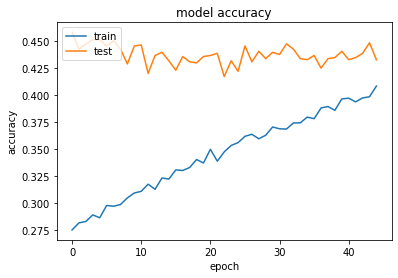

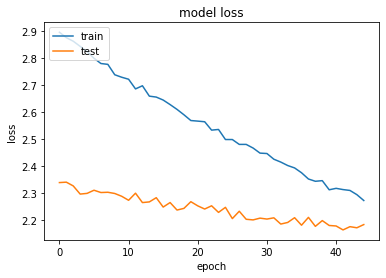

In [0]:
history = new_model224.fit_generator(datagen.flow(X_train, Y_train,batch_size = 128),
          validation_data = (X_val, Y_val),
          steps_per_epoch=len(X_train) // 128,
                    epochs=100, initial_epoch = 55,
               callbacks = [model_checkpoint]
                    
                    )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **SUMMARY OF ALL RUNS WITH VGG16**


Best results are with 224x224 so the summary is provided for that 

The trails conducted for different architechtures and hyper-parameters are as follows:
*   VGG16 with 1024 + 256 + 120 with softmax, learning rate = 10^-4, adam optimiser --> 45.8% validation accuracy 41% training accuracy **(BEST)**
*   VGG16 with 2048 + 1024 + 120 with softmax, learning rate = 10^-4, adam optimiser --> 26.4% validation accuracy 78% training accuracy (overfit)


*   VGG16 with 1024 + 120 with softmax, learning rate = 10^-4, adam optimiser --> 36.1% validation accuracy 65% training accuracy (overfit)
*   VGG16 with 1024 + 1024 + 120 with softmax, learning rate = 10^-3, adam optimiser --> 15.4% validation accuracy 99% training accuracy (overfit)


*   VGG16 with 1024 + 1024 + 120 with softmax, learning rate = 10^-4, adam optimiser with no horizontal flip --> 39% validation accuracy 42% training accuracy 
*   VGG16 with 1024 + 1024 + 120 with sigmoid, learning rate = 10^-4 with 0.99 momentum and nesterov = True, SGD optimiser --> 31% validation accuracy 89% training accuracy (overfit)


**Based on the above trial with VGG16 the submission file (sub.csv) is written for VGG16 with 1024 + 256 + 120 with softmax, learning rate = 10^-4, adam optimiser --> 45.8% validation accuracy 41% training accuracy (BEST)**









# CREATION OF SUBMISSION FILE

In [16]:
y_test

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,english_foxhound,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,

In [0]:
pred = new_model224.predict(x_test_scaled)

In [24]:
predicted_classes = np.argmax(pred, axis = -1)
predicted_classes


array([115,  94,  40, ...,  69, 109,  97])

In [26]:
predictions = []
for classes in predicted_classes:
  predictions.append(y_test.columns[classes])

predictions

['welsh_springer_spaniel',
 'samoyed',
 'english_setter',
 'afghan_hound',
 'tibetan_terrier',
 'chow',
 'australian_terrier',
 'pomeranian',
 'scottish_deerhound',
 'sussex_spaniel',
 'tibetan_terrier',
 'sealyham_terrier',
 'irish_water_spaniel',
 'dingo',
 'bloodhound',
 'leonberg',
 'basenji',
 'afghan_hound',
 'irish_terrier',
 'golden_retriever',
 'irish_wolfhound',
 'eskimo_dog',
 'mexican_hairless',
 'labrador_retriever',
 'irish_setter',
 'dhole',
 'beagle',
 'whippet',
 'english_setter',
 'kerry_blue_terrier',
 'scotch_terrier',
 'norwegian_elkhound',
 'clumber',
 'toy_terrier',
 'saluki',
 'japanese_spaniel',
 'japanese_spaniel',
 'yorkshire_terrier',
 'english_springer',
 'german_short-haired_pointer',
 'bedlington_terrier',
 'scottish_deerhound',
 'brabancon_griffon',
 'airedale',
 'border_collie',
 'bernese_mountain_dog',
 'welsh_springer_spaniel',
 'papillon',
 'toy_terrier',
 'clumber',
 'beagle',
 'silky_terrier',
 'malamute',
 'blenheim_spaniel',
 'weimaraner',
 'mexi

In [28]:
sub = pd.DataFrame(data = pred, index = submision.id, columns = y_test.columns)
sub

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,english_foxhound,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000621fb3cbb32d8935728e48679680e,0.001051,1.873785e-02,0.032793,2.636800e-03,4.941280e-03,5.539417e-03,1.876988e-03,0.001947,2.973692e-02,0.039969,0.001505,3.437903e-03,1.391856e-02,2.370280e-02,1.287595e-02,2.613572e-02,0.003040,3.691994e-03,0.009206,0.002146,8.530026e-04,9.582481e-03,2.523505e-03,4.384473e-03,1.589291e-02,0.016863,0.000879,0.006487,1.339754e-02,0.002190,0.002153,7.654240e-03,1.089501e-02,0.017506,3.587198e-03,0.001724,0.014639,0.005749,1.715236e-03,7.689799e-03,...,0.012911,0.000703,0.001485,1.981795e-03,0.006444,0.005877,0.002308,0.001196,0.018267,6.950467e-03,1.943158e-02,5.864278e-03,0.016393,0.042076,0.000989,0.000666,0.000597,5.600565e-03,0.001183,0.009876,0.003448,0.008712,8.217722e-03,9.163285e-04,4.017293e-03,1.624142e-03,2.390009e-03,9.006322e-03,6.170890e-03,1.156527e-02,0.000454,0.001088,4.353946e-03,1.630093e-02,1.227670e-02,4.278355e-02,0.000499,1.967330e-02,0.000724,1.509213e-03
00102ee9d8eb90812350685311fe5890,0.000001,5.439068e-08,0.000005,6.386808e-09,6.729178e-07,4.873548e-07,5.201221e-07,0.000008,1.601524e-08,0.000001,0.000001,4.614002e-07,9.312658e-09,1.138392e-07,5.821947e-09,1.386595e-08,0.002213,1.009502e-08,0.000049,0.000020,2.377077e-07,4.479377e-07,1.707212e-07,1.316438e-07,5.619668e-07,0.000002,0.000023,0.000434,2.450988e-07,0.000027,0.000495,5.717176e-07,1.071022e-07,0.002986,8.186387e-08,0.000001,0.000011,0.000055,1.315327e-07,1.125161e-07,...,0.000265,0.000002,0.000027,1.561788e-07,0.000085,0.000005,0.001183,0.005775,0.000002,5.786159e-08,4.444039e-09,1.194551e-07,0.000003,0.000001,0.534377,0.000440,0.000066,8.850346e-08,0.000023,0.000353,0.000002,0.340362,4.981437e-09,6.639444e-07,8.980024e-07,6.012768e-07,1.104662e-08,9.518312e-09,7.665193e-07,1.849995e-07,0.000006,0.000008,5.598338e-08,3.615229e-07,2.165280e-07,3.373735e-07,0.001184,5.592908e-07,0.000007,2.015989e-07
0012a730dfa437f5f3613fb75efcd4ce,0.001159,6.698846e-02,0.003832,1.073298e-02,8.955132e-04,6.329154e-04,2.936355e-03,0.000346,2.271279e-03,0.002726,0.007935,1.454278e-03,2.533067e-03,3.022657e-03,6.789608e-03,7.063203e-03,0.003453,9.220866e-03,0.036021,0.000402,1.764003e-03,4.437405e-04,6.624572e-04,1.873126e-02,5.039886e-03,0.003212,0.008190,0.000519,4.076688e-03,0.000809,0.000534,6.525727e-02,1.753310e-02,0.005638,1.657647e-03,0.029810,0.002031,0.002202,4.146691e-04,1.496966e-03,...,0.000951,0.002383,0.008018,2.312750e-02,0.000839,0.002200,0.000657,0.000557,0.004382,1.216427e-03,1.753026e-03,9.509549e-04,0.002110,0.028457,0.001967,0.000288,0.001074,6.528758e-02,0.022113,0.003401,0.003910,0.000902,4.549271e-03,7.311378e-03,5.585288e-04,3.212576e-03,1.400358e-02,1.533270e-02,1.889924e-03,2.264444e-02,0.001694,0.000587,2.584221e-03,1.649314e-03,7.898307e-03,1.200303e-02,0.002061,6.687847e-03,0.004320,2.658817e-03
001510bc8570bbeee9

In [0]:
sub.to_csv('./sub.csv')

This sub.csv can now be uploaded to kaggle to check test accuracy.

# TRIALS WITH OTHER BASE MODELS - ResNet50

In [0]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
tf.keras.backend.clear_session()
base_model2= ResNet50(weights='imagenet',
                 include_top=False, pooling='avg', input_shape = (64,64,3))
base_model2.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
__________________________

In [0]:

new_model2 = tf.keras.models.Sequential()
new_model2.add(base_model2)
new_model2.summary()
#base_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [0]:

#Add Dense Layers after flattening the data
new_model2.add(tf.keras.layers.Flatten())
new_model2.add(tf.keras.layers.Dense(1024, activation='relu'))
new_model2.add(tf.keras.layers.Dropout(0.5))
new_model2.add(tf.keras.layers.BatchNormalization())
#new_model.add(tf.keras.layers.Dense(4096, activation='relu'))
#new_model.add(tf.keras.layers.BatchNormalization())
#new_model.add(tf.keras.layers.Dense(4096, activation='relu'))
#new_model.add(tf.keras.layers.BatchNormalization())
new_model2.add(tf.keras.layers.Dense(256, activation='relu'))
new_model2.add(tf.keras.layers.Dropout(0.5))
new_model2.add(tf.keras.layers.BatchNormalization())

#Add Output Layer
new_model2.add(tf.keras.layers.Dense(120, activation='softmax'))

In [0]:
for layer in new_model2.layers[:1]:
  layer.trainable = False

In [0]:
for layer in new_model2.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.training.Model object at 0x7fbb022fd8d0> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7fb9e3736c88> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fb9e3736cc0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7fb9e3736ef0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb9e3738710> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fb9e3738278> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7fb9e374cfd0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb9e36f1f60> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fb9e3753048> True


In [0]:
new_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [0]:
#Specify Loass and Optimizer
adm = optimizers.Adam(lr = 0.0001)
new_model2.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('first_model_resnet.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [0]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
new_model2.fit_generator(datagen.flow(X_train, Y_train,batch_size = 128),
          validation_data = (X_val, Y_val),
          steps_per_epoch=len(X_train) // 128,
                    epochs=100, 
               callbacks = [model_checkpoint]
                    
                    )

  ...
    to  
  ['...']
Train for 71 steps, validate on 1023 samples
Epoch 1/100
70/71 [============================>.] - ETA: 0s - loss: 5.4372 - accuracy: 0.0092
Epoch 00001: val_accuracy improved from -inf to 0.01369, saving model to first_model_resnet.h5
71/71 [==============================] - 17s 245ms/step - loss: 5.4330 - accuracy: 0.0094 - val_loss: 4.8509 - val_accuracy: 0.0137
Epoch 2/100
70/71 [============================>.] - ETA: 0s - loss: 5.3795 - accuracy: 0.0095
Epoch 00002: val_accuracy did not improve from 0.01369
71/71 [==============================] - 11s 151ms/step - loss: 5.3764 - accuracy: 0.0096 - val_loss: 4.8616 - val_accuracy: 0.0137
Epoch 3/100
70/71 [============================>.] - ETA: 0s - loss: 5.3263 - accuracy: 0.0096
Epoch 00003: val_accuracy did not improve from 0.01369
71/71 [==============================] - 11s 149ms/step - loss: 5.3274 - accuracy: 0.0095 - val_loss: 4.8703 - val_accuracy: 0.0137
Epoch 4/100
70/71 [=========================

### Accuracy with ResNet is very poor. Inception was also tried. Results were not encouraging. So attempt was discarded. 